#### This notebook is used to segment the LHA based on selective enrichment of Slc17a6/Slc32a1 and Otp/Meis2

In [1]:
import os, sys,z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.io import imread, imsave
from os.path import abspath, dirname
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
from scipy import stats, spatial
import seaborn as sns
from scipy import ndimage, misc
from matplotlib.colors import DivergingNorm, LogNorm,BoundaryNorm, Normalize
sns.set(style='ticks', palette='Set2')
from sklego.mixture import GMMClassifier
from sklego.mixture import GMMOutlierDetector

In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

######Load spot count #####

In [ ]:
lha_neuron=pd.read_csv('directory/spotcount/neuron',sep=',', index_col=0)
ex_m=pd.read_csv('/Slc17a6/molecular/type/metadata',sep=',', index_col=0)
inh_m=pd.read_csv('/Slc32a1/molecular/type/metadata',sep=',', index_col=0)
lha_neuron=lha_neuron.T
lha_neuron=lha_neuron.where(lha_neuron>=0, 0)
roi=pd.read_csv('directory/roi/metadata',sep=',', index_col=0)

cluster=pd.concat([ex_m,inh_m],axis=0)

c=['Ex-1', 'Ex-2', 'Ex-3', 'Ex-4',
   'Ex-5', 'Ex-6', 'Ex-7', 'Ex-8', 
   'Ex-9', 'Ex-10', 'Ex-11', 'Ex-12', 
   'Ex-13', 'Ex-14', 'Ex-15', 'Ex-16', 
   'Ex-17', 'Ex-18', 'Ex-19', 'Ex-20',
   'Ex-21', 'Ex-22', 'Ex-23', 'Ex-24', 
   'Ex-25','Inh-1', 'Inh-2','Inh-3', 'Inh-4', 
   'Inh-5', 'Inh-6', 'Inh-7', 'Inh-8', 'Inh-9', 
   'Inh-10', 'Inh-11', 'Inh-12', 'Inh-13', 'Inh-14',
   'Inh-15', 'Inh-16', 'Inh-17', 'Inh-18', 'Inh-19',
   'Inh-20', 'Inh-21', 'Inh-22', 'Inh-23']

In [12]:
lha_neuron=pd.read_csv('/Users/wangy6/Desktop/FISH/LHA_FISH_gene.csv',sep=',', index_col=0)
ex_m=pd.read_csv('/Users/wangy6/Desktop/LHA_figures/Slc17a6_metadata_tsne_v6.csv',sep=',', index_col=0)
inh_m=pd.read_csv('/Users/wangy6/Desktop/LHA_figures/Slc32a1_metadata_tsne_v6.csv',sep=',', index_col=0)
lha_neuron=lha_neuron.T
lha_neuron=lha_neuron.where(lha_neuron>=0, 0)
ex_m.x='Ex_' + ex_m.x.astype(str)
inh_m.x='Inh_' + ex_m.x.astype(str)

#roi=roi[(roi.region=='LHA3')|(roi.region=='LHA4')|(roi.region=='LHA5')]
# Otp_Meis2=pd.read_csv('/Volumes/multifish/Yuhan/LHA_analysis/anatomy/20200921_mFISH_roi_meta_v9_in_microns_fractions_Otp_Meis2_v3.csv', sep=',', index_col=0)

'Nearest neighbor analysis for other cell types'



In [22]:
Ex_12=ex_m[ex_m.x=='Ex_12']
Ex_25=ex_m[ex_m.x=='Ex_25']

roi.loc[:, 'om_cluster']='N'
otp=lha_neuron[lha_neuron.Otp>50]
meis2=lha_neuron[lha_neuron.Meis2>50]
roi.loc[otp.index, 'om_cluster']='O'
roi.loc[meis2.index, 'om_cluster']='M'

roi.loc[ex_m.index, 'ex_cluster']='E'
roi.loc[Ex_12.index, 'ex_cluster']='O'
roi.loc[Ex_25.index, 'ex_cluster']='O'
roi.loc[inh_m.index, 'ex_cluster']='I'

roi['om_cluster']=roi['om_cluster'].astype(str)
roi['ex_cluster']=roi['ex_cluster'].astype(str)

a = np.linspace(130, 789, 659)  
b = np.linspace(30, 787, 757)
c= np.linspace(0, 265, 265)   
xa, xb,xc = np.meshgrid(a, b, c) 
U=pd.DataFrame(data=np.zeros((xa.flatten().shape[0],3)),columns=['z','y','x'])
U.loc[:,'x'] = xa.flatten()
U.loc[:,'y'] = xb.flatten()
U.loc[:,'z'] = xc.flatten()
X=roi.to_numpy()[:,:3]
radius   = 50  
neuron=spatial.KDTree(U)
neighbors=neuron.query_ball_point(X,radius)
U.loc[:,'fraction_o_m']=0
U.loc[:,'fraction_ex_in']=0

for i in range(0,len(neighbors)):
    x=[]
    y=[]
    for j in neighbors[i]:
        x=np.append(x, roi.iloc[j,26])
        y=np.append(y, roi.iloc[j,25])
    a,b=np.unique(x,return_counts=True)
    c,d=np.unique(y,return_counts=True)
    if np.any(a=='E') and np.any(a=='I'):
        E=b[np.argwhere(a=='E')]
        I=b[np.argwhere(a=='I')]
        roi.iloc[i,28]=float((E-I)/(E+I))
    else:
        if np.any(a=='E'):
            roi.iloc[i,28]=1
        if np.any(a=='I'):
            roi.iloc[i,28]=-1
            
    if np.any(c=='O') and np.any(c=='M'):
        o=d[np.argwhere(c=='O')]
        m=d[np.argwhere(c=='M')]
        roi.iloc[i,27]=float((o-m)/(o+m))
    else:
        if np.any(c=='O'):
            roi.iloc[i,27]=1
        if np.any(c=='M'):
            roi.iloc[i,27]=-1

Text(0.15, 1, 'Otp/Meis2')

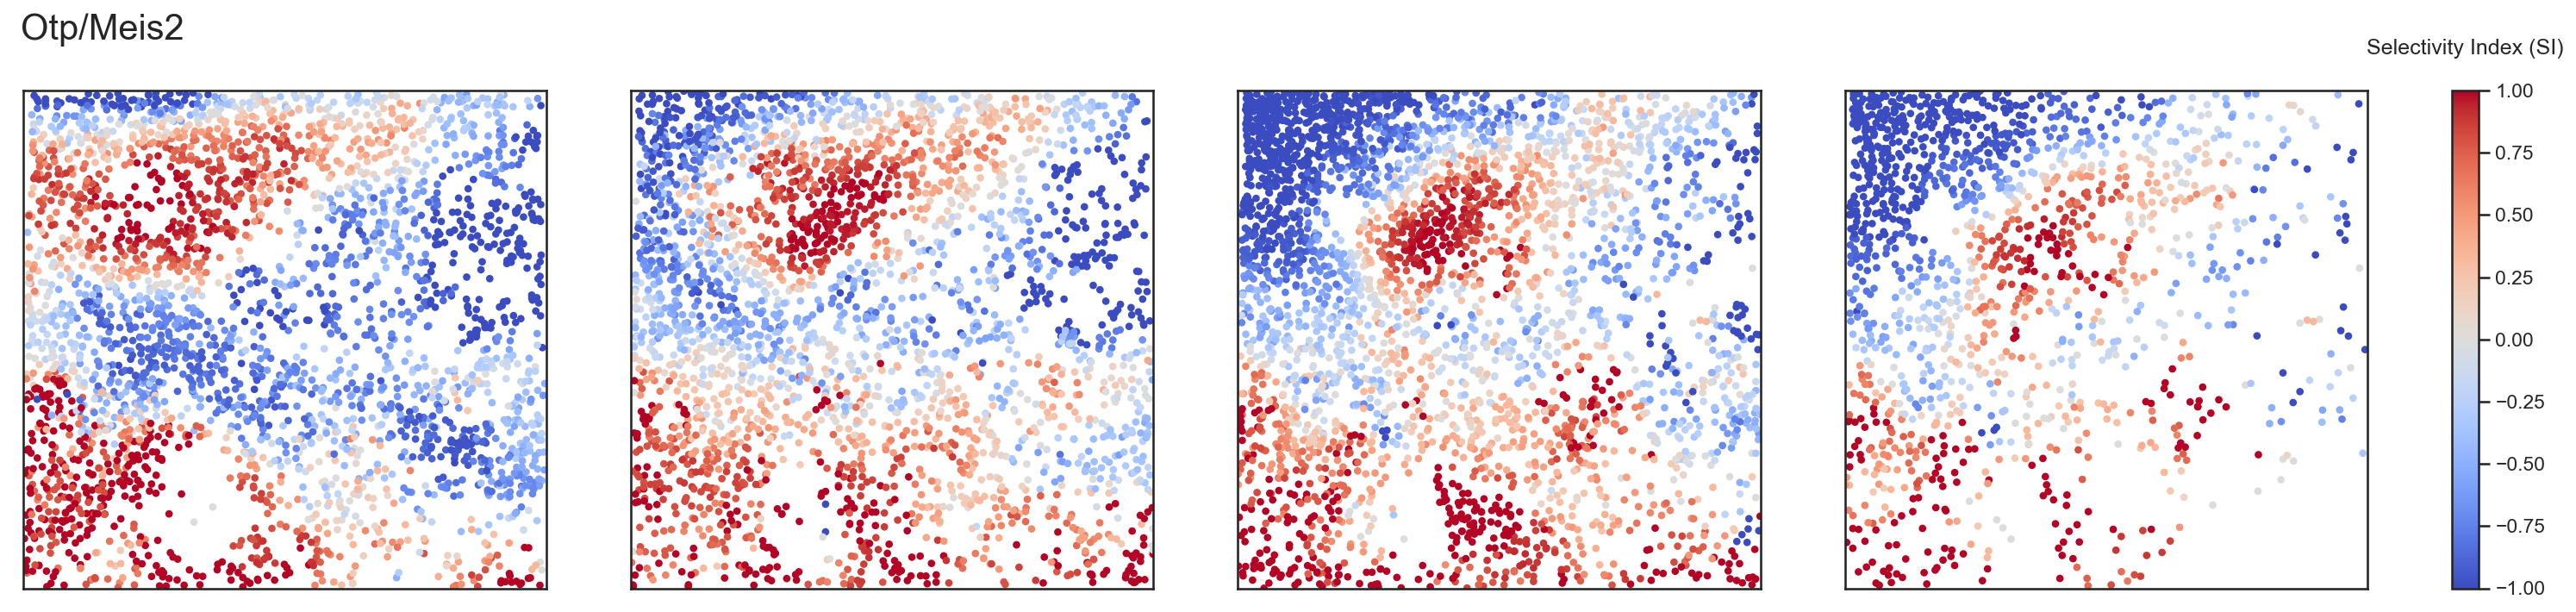

In [27]:
fig, ax = plt.subplots(1,5,figsize=(24.5,5),dpi=150, gridspec_kw={"width_ratios":[1,1,1,1,0.05]})
ind=0
A=roi.copy()
A=A[(A.x<777)&(A.y<772)&(A.z<266)]
for z in [206,146,86,26]:
    B=A[(A.z>(z-60))&(A.z<=z)]
    x=A[A.index.isin(B.index)]['fraction_o_m'].astype(float)
    a=ax[ind].scatter(B.to_numpy()[:,2],(B.to_numpy()[:,1]), c=x, 
                                    marker='o', s=10, cmap=plt.cm.coolwarm,alpha=1)
    ax[ind].xaxis.set_ticklabels([])
    ax[ind].yaxis.set_ticklabels([])
    ax[ind].xaxis.set_ticks([])
    ax[ind].yaxis.set_ticks([])
    ax[ind].set_ylim(36,772)
    ax[ind].set_xlim(2,777)
    ax[ind].invert_yaxis()
    ind+=1
cb=fig.colorbar(a, cax=ax[ind], shrink=0.1,aspect=10,pad=0.5)
cb.ax.set_title("Selectivity Index (SI)",size=12, pad=20)
plt.suptitle('Otp/Meis2',size=20,x=0.15,y=1)

Text(0.15, 1, 'Slc17a6/Slc32a1')

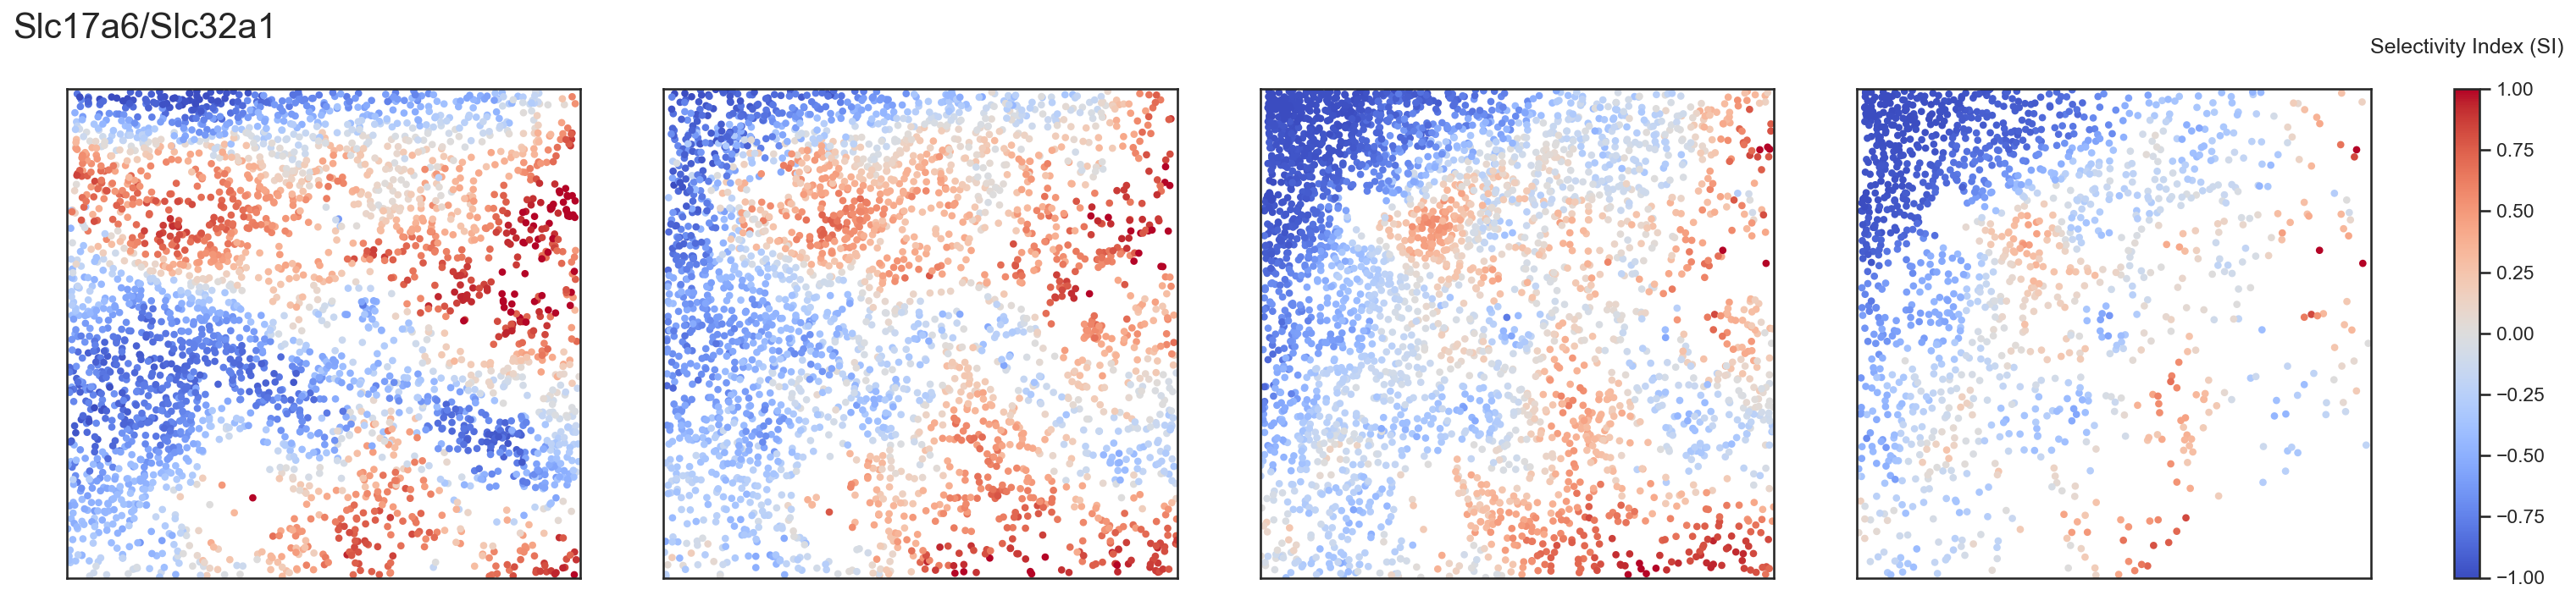

In [29]:
fig, ax = plt.subplots(1,5,figsize=(24.5,5),dpi=150, gridspec_kw={"width_ratios":[1,1,1,1,0.05]})
ind=0
A=roi.copy()
A=A[(A.x<777)&(A.y<772)&(A.z<266)]
for z in [206,146,86,26]:
    B=A[(A.z>(z-60))&(A.z<=z)]
    x=A[A.index.isin(B.index)]['fraction_ex_in'].astype(float)
    a=ax[ind].scatter(B.to_numpy()[:,2],(B.to_numpy()[:,1]), c=x, 
                                    marker='o', s=10, cmap=plt.cm.coolwarm,alpha=1)
    ax[ind].xaxis.set_ticklabels([])
    ax[ind].yaxis.set_ticklabels([])
    ax[ind].xaxis.set_ticks([])
    ax[ind].yaxis.set_ticks([])
    ax[ind].set_ylim(36,772)
    ax[ind].set_xlim(2,777)
    ax[ind].invert_yaxis()
    ind+=1
cb=fig.colorbar(a, cax=ax[ind], shrink=0.1,aspect=10,pad=0.5)
cb.ax.set_title("Selectivity Index (SI)",size=12, pad=20)
plt.suptitle('Slc17a6/Slc32a1',size=20,x=0.15,y=1)

###### Classification based on Slc17a6, Slc32a1, Otp and Meis2

In [4]:
for i in roi.index:
    if roi.loc[i, 'fraction_o_m']> 0:
        if roi.loc[i, 'fraction_ex_in']> 0:
            roi.loc[i,'classifier']='1' #ex_otp
        else:
            roi.loc[i,'classifier']='2'  #inh_otp
    else:
        if roi.loc[i, 'fraction_ex_in']> 0:
            roi.loc[i,'classifier']='3' #ex_meis2
        else:
            roi.loc[i,'classifier']='4' #inh_meis2

###### LHA segmentation using Gaussian mixture model
The code below is for demonstration purpose. 
For the analysis described in the paper, entire image volumes were segmented at 1µm resolution from all biological replicates.  

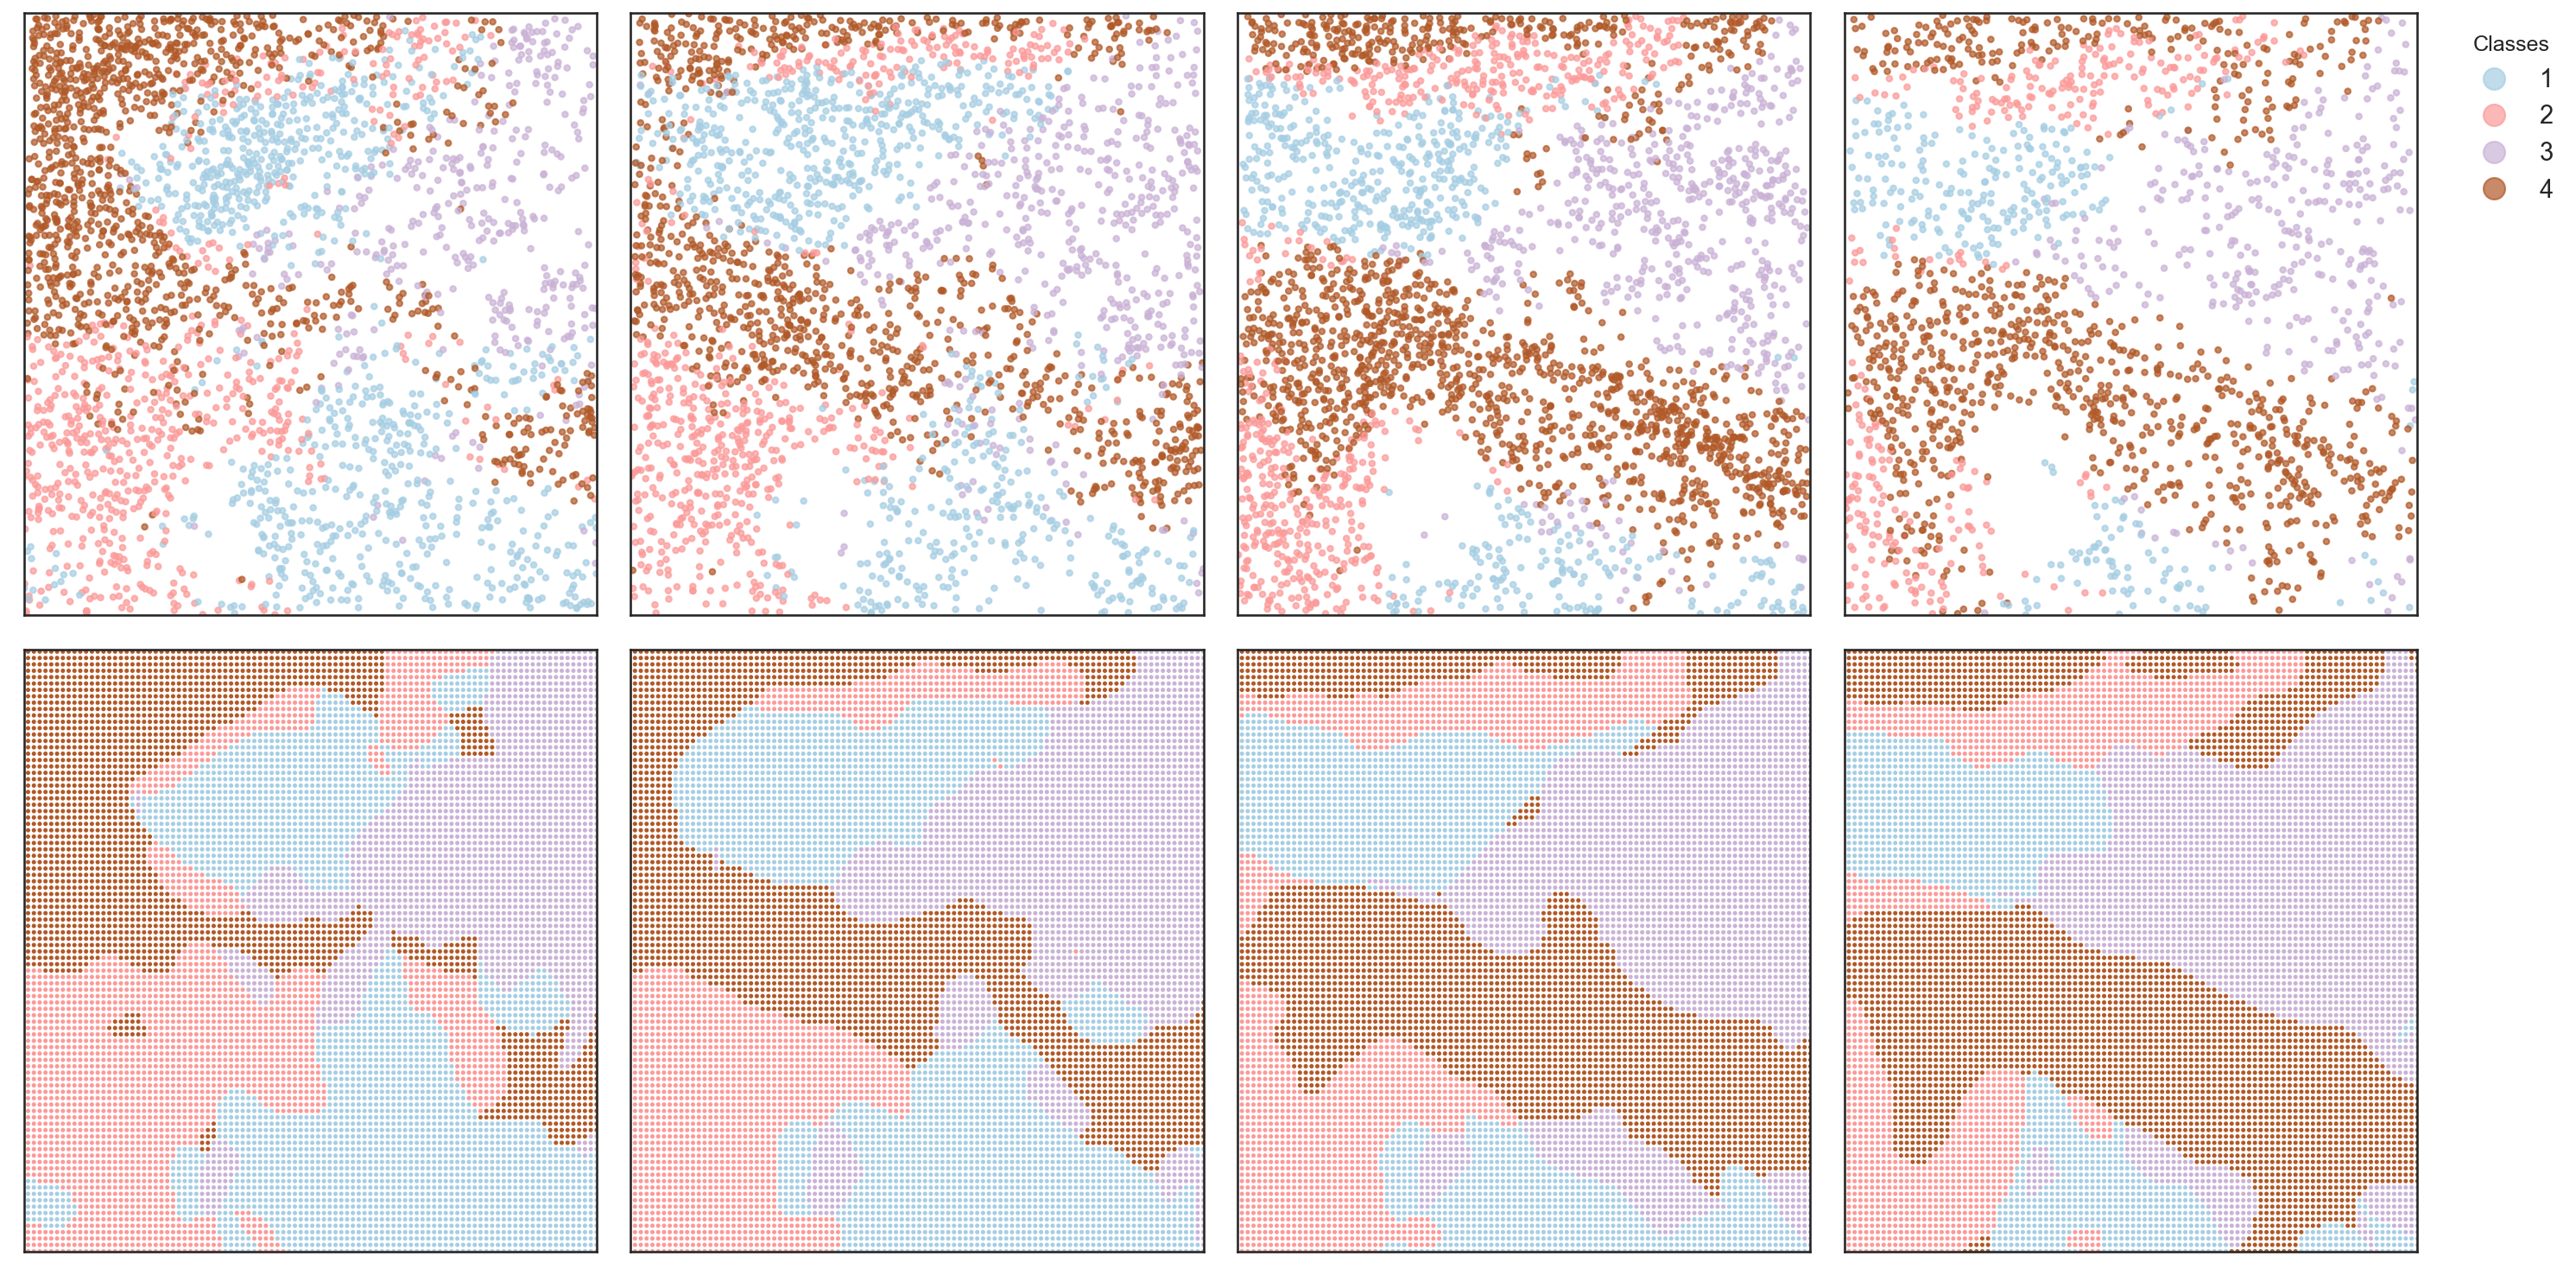

In [17]:
###3D model 

fig,ax=plt.subplots(2,4,figsize=(20,10),dpi=150)
ind=0
A=roi.copy()
A=A[(A.x<777)&(A.y<772)&(A.z<266)]
A.z=A.z.max()-A.z

mod = GMMClassifier(n_components=50).fit(A.to_numpy()[:,0:3][:,[2,1,0]], A['classifier'])

for z in [206,146,86,36]:
    B=A[(A.z>(z-60))&(A.z<=z)]
    a = np.linspace(0, 777, 100)  
    b = np.linspace(0, 772, 100)
    c= np.linspace(z-20, z-19, 1)   
    xa, xb,xc = np.meshgrid(a, b, c) 
    U=np.zeros((xa.flatten().shape[0],3))
    U[:,0] = xa.flatten()
    U[:,1] = xb.flatten()
    U[:,2] = xc.flatten()
    Z=mod.predict(U).astype(float)
    a=ax[1,ind].scatter(U[:, 0], U[:, 1], c=Z, s=2,cmap=plt.cm.Paired)
    a=ax[0,ind].scatter(B.x, B.y, c=B.classifier.astype('float'), s=10,alpha=0.7,cmap=plt.cm.Paired)
    for mm in range(0,2):
        ax[mm,ind].xaxis.set_ticklabels([])
        ax[mm,ind].yaxis.set_ticklabels([])
        ax[mm,ind].xaxis.set_ticks([])
        ax[mm,ind].yaxis.set_ticks([])
        ax[mm,ind].set_ylim(36,772)
        ax[mm,ind].set_xlim(2,777)
        ax[mm,ind].invert_yaxis()
    ind+=1
legend1 = ax[0,ind-1].legend(*a.legend_elements(),
                        title="Classes",fontsize=14,
                        markerscale=2,bbox_to_anchor=(1.05, 1.0), 
                             loc='upper left',frameon=False)
plt.tight_layout()

###### Find the optimal n_components to use for 3D parcellation

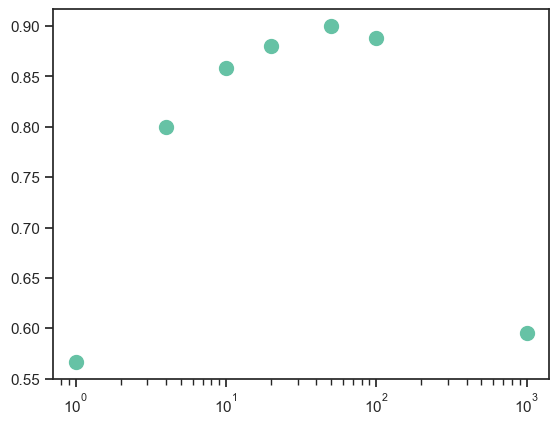

In [17]:
A=roi.copy()
A=A[(A.x<789)&(A.x>130)&(A.y>30)&(A.y<787)&(A.z>83)&(A.z<348)]
s=45
A.z=A.z.max()-A.z
n=8000
idx=np.random.choice(A.index,n)
X_train=A[A.index.isin(idx)].to_numpy()[:,0:3][:,[2,1,0]]
Y_train=A[A.index.isin(idx)]['classifier']

idx_t=np.random.choice(A[~A.index.isin(idx)].index, n)
X_test=A[A.index.isin(idx_t)].to_numpy()[:,0:3][:,[2,1,0]]
Y_test=A[A.index.isin(idx_t)]['classifier']
score={}
for i in [1,4,10,20,50,100,1000]:
    mod = GMMClassifier(n_components=i).fit(X_train, Y_train)
    score[i]=mod.score(X_test, Y_test)
plt.scatter(score.keys(),score.values(),s=100)
plt.xscale('log')    